In [1]:
import torch
import torch.optim as optim

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # Celsius
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # unknown
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples) # random permutation of ints from 0 to n_samples - 1
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([ 1,  6,  9,  8,  5,  3,  7,  0, 10]), tensor([2, 4]))

In [4]:
train_t_u = t_u[train_indices].unsqueeze(1)
train_t_c = t_c[train_indices].unsqueeze(1)

val_t_u = t_u[val_indices].unsqueeze(1)
val_t_c = t_c[val_indices].unsqueeze(1)

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

## Artificial Neural Networks
Note: saturated when changes in input result in little/no changes to output.

PyTorch has building blocks called modules. A PyTorch module is a class derived from nn.Module and can have one or more Parameter instances as attributes, which are tensors whose value is optimized during the training process.

In [5]:
import torch.nn as nn

# Linear is a subclass of nn.Module, which means it has a __call__ method defined. Use it.
linear_model = nn.Linear(1, 1) # args are input size, output size, bias(=True default)
linear_model(val_t_un.unsqueeze(1))

tensor([[[-4.1361]],

        [[-3.9751]]], grad_fn=<AddBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.8473]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.7953], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.0520], grad_fn=<AddBackward0>)

Any module in ```nn``` written to produce output for a batch of multiple inputs. The first dimension of the input is the batch dim.

Need tensor of size B x Nin where B is size of batch and Nin is number of inputs. For example, for 10 samples need 10 x 1 input.

Output is tensor of size B x Nout.

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.0520],
        [-0.0520],
        [-0.0520],
        [-0.0520],
        [-0.0520],
        [-0.0520],
        [-0.0520],
        [-0.0520],
        [-0.0520],
        [-0.0520]], grad_fn=<AddmmBackward0>)

Change prev input to be of desired input form B x Nin.

In [10]:
t_c = t_c.unsqueeze(1)
t_u = t_u.unsqueeze(1)
t_c.shape, t_u.shape

(torch.Size([11, 1]), torch.Size([11, 1]))

Now fit model.

In [11]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.4061]], requires_grad=True),
 Parameter containing:
 tensor([-0.2528], requires_grad=True)]

Now create training loop with model passed in instead of individual params. Also use loss functions from ```torch.nn``` directly, which are subclasses of ```nn.Module``` so need to be created as an instance.

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val, print_vals=True):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        train_loss = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        val_loss = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if print_vals:
            if (epoch == 1 or epoch % 1000 == 0) and (epoch != n_epochs):
                print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                      f" Validation loss {val_loss.item():.4f}")
    print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
              f" Validation loss {val_loss.item():.4f}")

In [14]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(3000, optimizer, linear_model, nn.MSELoss(), train_t_un, val_t_un, train_t_c, val_t_c)

print(linear_model.weight, linear_model.bias)

Epoch 1, Training loss 90.9806, Validation loss 62.7878
Epoch 1000, Training loss 3.5465, Validation loss 2.5739
Epoch 2000, Training loss 3.0434, Validation loss 2.5045
Epoch 3000, Training loss 3.0355, Validation loss 2.4961
Parameter containing:
tensor([[5.3719]], requires_grad=True) Parameter containing:
tensor([-17.2280], requires_grad=True)


Extending model to have one hidden layer.

In [15]:
seq_model = nn.Sequential(nn.Linear(1, 13), 
                          nn.Tanh(), 
                          nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [16]:
[param.shape for param in seq_model.parameters()] # weight and bias from both first and second linear modules

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [17]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Can also explicitly name layers.

In [18]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([('hidden_linear', nn.Linear(1, 8)),
                                       ('hidden_activation', nn.Tanh()),
                                       ('output_linear', nn.Linear(8, 1))
                                      ]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [20]:
seq_model.output_linear.weight 

Parameter containing:
tensor([[ 0.2599,  0.2669,  0.1643,  0.3208,  0.0530,  0.0124,  0.1690, -0.0409]],
       requires_grad=True)

In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2942], requires_grad=True)

Run training loop with sequential model.

In [22]:
optimizer = optim.SGD(seq_model.parameters(), 1e-3)

training_loop(5000, optimizer, seq_model, nn.MSELoss(), train_t_un, val_t_un, train_t_c, val_t_c)

print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 203.1317, Validation loss 189.2796
Epoch 1000, Training loss 4.7918, Validation loss 2.5514
Epoch 2000, Training loss 3.6606, Validation loss 4.9500
Epoch 3000, Training loss 2.1354, Validation loss 1.9012
Epoch 4000, Training loss 1.9113, Validation loss 1.8788
Epoch 5000, Training loss 1.8342, Validation loss 1.9448
output tensor([[13.3735],
        [12.1154]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [11.]])
hidden tensor([[ 0.0101],
        [-0.0186],
        [-0.0200],
        [-0.0232],
        [-0.0178],
        [ 0.0113],
        [-0.0074],
        [ 0.0266]])


Compare with linear model.

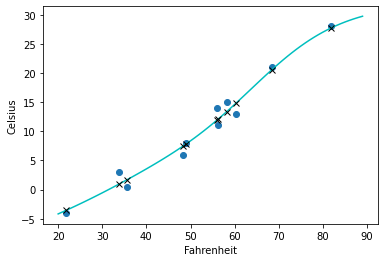

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20, 90).unsqueeze(1)
fig, ax = plt.subplots()
ax.set(xlabel="Fahrenheit", ylabel="Celsius")
ax.plot(t_u.numpy(), t_c.numpy(), 'o') # correct labels
ax.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-') # whole curve (behavior between samples)
ax.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx') # fitted values

## Exercises
**1. Changing number of hidden neurons and learning rate.**

In [24]:
def run_model(n_neurons, learning_rate=1e-3, print_vals=False, print_weights=False):
    seq_model = nn.Sequential(nn.Linear(1, n_neurons), 
                              nn.Tanh(), 
                              nn.Linear(n_neurons, 1))

    optimizer = optim.SGD(seq_model.parameters(), learning_rate)

    training_loop(5000, optimizer, seq_model, nn.MSELoss(), train_t_un, val_t_un, train_t_c, val_t_c, print_vals)
    
    print('output', seq_model(val_t_un))
    if print_weights:        
        print('answer', val_t_c)
        print('hidden', seq_model[2].weight.grad)

In [25]:
for n in range(1, 11):
    print(f'\n{n} neurons in hidden layer:\n')
    run_model(n)


1 neurons in hidden layer:

Epoch 5000, Training loss 13.6701, Validation loss 29.5779
output tensor([[10.7769],
        [ 8.8936]], grad_fn=<AddmmBackward0>)

2 neurons in hidden layer:

Epoch 5000, Training loss 2.9871, Validation loss 5.9727
output tensor([[14.3782],
        [12.7827]], grad_fn=<AddmmBackward0>)

3 neurons in hidden layer:

Epoch 5000, Training loss 1.8457, Validation loss 2.2080
output tensor([[13.5465],
        [12.2392]], grad_fn=<AddmmBackward0>)

4 neurons in hidden layer:

Epoch 5000, Training loss 1.8269, Validation loss 1.9150
output tensor([[13.2912],
        [11.9555]], grad_fn=<AddmmBackward0>)

5 neurons in hidden layer:

Epoch 5000, Training loss 1.7999, Validation loss 1.7881
output tensor([[13.1286],
        [11.8232]], grad_fn=<AddmmBackward0>)

6 neurons in hidden layer:

Epoch 5000, Training loss 1.8492, Validation loss 1.7803
output tensor([[12.9010],
        [11.6277]], grad_fn=<AddmmBackward0>)

7 neurons in hidden layer:

Epoch 5000, Training 

In [26]:
for n in range(10, 110, 10):
    print(f'\n{n} neurons in hidden layer:\n')
    run_model(n)


10 neurons in hidden layer:

Epoch 5000, Training loss 1.8191, Validation loss 1.8084
output tensor([[13.0271],
        [11.7614]], grad_fn=<AddmmBackward0>)

20 neurons in hidden layer:

Epoch 5000, Training loss 1.8232, Validation loss 1.9429
output tensor([[13.4234],
        [12.1833]], grad_fn=<AddmmBackward0>)

30 neurons in hidden layer:

Epoch 5000, Training loss 1.9030, Validation loss 2.1139
output tensor([[13.7308],
        [12.4965]], grad_fn=<AddmmBackward0>)

40 neurons in hidden layer:

Epoch 5000, Training loss 1.9273, Validation loss 2.1165
output tensor([[13.7663],
        [12.5594]], grad_fn=<AddmmBackward0>)

50 neurons in hidden layer:

Epoch 5000, Training loss 1.9289, Validation loss 2.0075
output tensor([[13.5408],
        [12.3732]], grad_fn=<AddmmBackward0>)

60 neurons in hidden layer:

Epoch 5000, Training loss 1.9191, Validation loss 2.0091
output tensor([[13.5254],
        [12.3579]], grad_fn=<AddmmBackward0>)

70 neurons in hidden layer:

Epoch 5000, Trai

So, in this case increasing the number of hidden neurons increases validation loss in general. Now change the learning rate.

In [27]:
for lr in [0.1**i for i in range(1, 11)]:
    print(f'\nLearning Rate: {lr}')
    run_model(13, lr)


Learning Rate: 0.1
Epoch 5000, Training loss nan, Validation loss nan
output tensor([[nan],
        [nan]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.010000000000000002
Epoch 5000, Training loss 1.3872, Validation loss 3.2450
output tensor([[13.1144],
        [12.4255]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0010000000000000002
Epoch 5000, Training loss 1.8569, Validation loss 2.1651
output tensor([[13.7125],
        [12.4424]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.00010000000000000002
Epoch 5000, Training loss 10.2521, Validation loss 2.7754
output tensor([[13.8992],
        [13.0831]], grad_fn=<AddmmBackward0>)

Learning Rate: 1.0000000000000003e-05
Epoch 5000, Training loss 86.2192, Validation loss 33.6671
output tensor([[7.5685],
        [7.5231]], grad_fn=<AddmmBackward0>)

Learning Rate: 1.0000000000000004e-06
Epoch 5000, Training loss 165.4729, Validation loss 140.7174
output tensor([[1.3110],
        [1.3028]], grad_fn=<AddmmBackward0>)

Learning Rate: 1.0000000

Validation loss is generally increasing as the learning rate decreases (past a certain point). Let's try learning rates around 1e-3, which seems to work best.

In [28]:
for lr in [1e-3*i for i in range(1, 10)]:
    print(f'\nLearning Rate: {lr}')
    run_model(13, lr)


Learning Rate: 0.001
Epoch 5000, Training loss 1.8866, Validation loss 2.2317
output tensor([[13.7997],
        [12.5216]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.002
Epoch 5000, Training loss 1.8277, Validation loss 2.3767
output tensor([[13.6764],
        [12.3676]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.003
Epoch 5000, Training loss 1.7798, Validation loss 1.9546
output tensor([[12.8456],
        [11.6816]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.004
Epoch 5000, Training loss 1.5803, Validation loss 2.0687
output tensor([[13.0278],
        [11.9628]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.005
Epoch 5000, Training loss 1.5748, Validation loss 2.0267
output tensor([[13.1364],
        [12.0113]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.006
Epoch 5000, Training loss 1.3573, Validation loss 2.2179
output tensor([[13.4203],
        [12.4018]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.007
Epoch 5000, Training loss 1.3641, Validation loss 2.2125
output tensor([

In [29]:
for lr in [1e-4*i for i in range(1, 10)]:
    print(f'\nLearning Rate: {lr}')
    run_model(13, lr)


Learning Rate: 0.0001
Epoch 5000, Training loss 11.5025, Validation loss 2.5825
output tensor([[13.7046],
        [12.8673]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0002
Epoch 5000, Training loss 4.2693, Validation loss 2.7351
output tensor([[14.3205],
        [13.2379]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.00030000000000000003
Epoch 5000, Training loss 2.5528, Validation loss 2.0953
output tensor([[13.9933],
        [12.7824]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0004
Epoch 5000, Training loss 2.0873, Validation loss 1.9220
output tensor([[13.7665],
        [12.5239]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0005
Epoch 5000, Training loss 1.9692, Validation loss 1.8714
output tensor([[13.7054],
        [12.4376]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0006000000000000001
Epoch 5000, Training loss 1.9409, Validation loss 1.8815
output tensor([[13.6668],
        [12.4091]], grad_fn=<AddmmBackward0>)

Learning Rate: 0.0007
Epoch 5000, Training loss 1.8732,

So, it appears the best learning rate according to validation loss is around 0.0008.

**2. Create new model for wine data. Copying normalization from Ch.4 notebook**

In [30]:
import pandas as pd
import numpy as np

In [31]:
wineq_pd = pd.read_csv('data/p1ch4/tabular-wine/winequality-white.csv', sep=';')
wineq = torch.from_numpy(wineq_pd.to_numpy(dtype=np.float32))

In [32]:
wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

Now have a floating point tensor with all the columns including the last, which refers to the quality score.

In [33]:
data = wineq[:, :-1] # excluding score
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [34]:
target = wineq[:, -1]
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

One-hot encoding

In [35]:
target

tensor([6., 6., 6.,  ..., 6., 7., 6.])

In [36]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(1, target.unsqueeze(1).long(), 1.0) # for each row take idx corresp to element in target and set to 1.0 in target_onehot
# first arg is dim along which the following two args are specified, 
# second arg is a column tensor indicating idx of element to scatter,
# third arg is the elements/single scalar to scatter

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

More data prep

In [37]:
data_mean = torch.mean(data, dim=0)
data_mean # gets mean in every column

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [38]:
data_var = torch.var(data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

In [39]:
data_normalized = (data - data_mean)/torch.sqrt(data_var)

Now back to new analysis. Use normalized data and one-hot encoding of target.

In [40]:
data_normalized.shape, target_onehot.shape

(torch.Size([4898, 11]), torch.Size([4898, 10]))

Create training and validation sets.

In [41]:
x, y = torch.utils.data.random_split(range(10), [3, 7])
[i for i in x], [i for i in y]

([8, 1, 9], [4, 6, 3, 0, 2, 5, 7])

In [42]:
train_size = int(data_normalized.shape[0]*0.8)
val_size = data_normalized.shape[0] - train_size
train_set, val_set = torch.utils.data.random_split(data_normalized, [train_size, val_size])

Using [this to get training and validation split](https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets).

In [43]:
indices = list(range(data_normalized.shape[0]))
np.random.shuffle(indices)
split_idx = int(data_normalized.shape[0]*0.8)
train_idxs, val_idxs = indices[:split_idx], indices[split_idx:]

In [44]:
train_set = data_normalized[train_idxs]
val_set = data_normalized[val_idxs]
train_output = target_onehot[train_idxs]
val_output = target_onehot[val_idxs]

Now create and run a model.

In [45]:
n_inputs = data_normalized.shape[1]
n_outputs = target_onehot.shape[1]
n_hidden_neurons = 10
seq_model = nn.Sequential(nn.Linear(n_inputs, n_hidden_neurons),
                          nn.Tanh(),
                          nn.Linear(n_hidden_neurons, n_outputs),
                          nn.Softmax(dim=1)) # to represent probabilities

Adjust loss to work with one-hot target.

In [46]:
def cross_entropy(inp, out):
    return torch.mean(-1*torch.sum(torch.tensor(range(1, inp.shape[1] + 1))*torch.log(inp), dim=1))

In [47]:
cross_entropy(seq_model(train_set[:2]), train_output[:2])

tensor(129.9237, grad_fn=<MeanBackward0>)

In [48]:
learning_rate = 1e-2
optimizer = optim.SGD(seq_model.parameters(), learning_rate)

training_loop(10000, optimizer, seq_model, cross_entropy, train_set, val_set, train_output, val_output)

print('output', seq_model(val_set))
print('answer', val_output)
print('hidden', seq_model[2].weight.grad)

Epoch 1, Training loss 130.6483, Validation loss 130.6815
Epoch 1000, Training loss 118.3246, Validation loss 118.3244
Epoch 2000, Training loss 118.3227, Validation loss 118.3226
Epoch 3000, Training loss 118.3219, Validation loss 118.3219
Epoch 4000, Training loss 118.3215, Validation loss 118.3215
Epoch 5000, Training loss 118.3213, Validation loss 118.3212
Epoch 6000, Training loss 118.3211, Validation loss 118.3211
Epoch 7000, Training loss 118.3210, Validation loss 118.3210
Epoch 8000, Training loss 118.3209, Validation loss 118.3209
Epoch 9000, Training loss 118.3208, Validation loss 118.3208
Epoch 10000, Training loss 118.3208, Validation loss 118.3208
output tensor([[0.0182, 0.0362, 0.0545,  ..., 0.1454, 0.1641, 0.1820],
        [0.0180, 0.0364, 0.0544,  ..., 0.1457, 0.1632, 0.1822],
        [0.0181, 0.0367, 0.0544,  ..., 0.1460, 0.1634, 0.1808],
        ...,
        [0.0179, 0.0362, 0.0543,  ..., 0.1454, 0.1636, 0.1822],
        [0.0181, 0.0364, 0.0545,  ..., 0.1454, 0.1635, 

Come back to this once I have a bit more understanding.